In [1]:
import os
import numpy as np
import pandas as pd
import setuptools
try:
    import ROOT
    import root_numpy
except ImportError as e:
    warnings.warn("Error importing ROOT-related libraries: %s. "
                  "If you try to use ROOT-related functions, hax will crash!" % e)

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['image.cmap'] = 'viridis'


In [20]:
from sklearn.mixture import GMM

In [4]:
path="/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/"

In [5]:
elem_charge = 1.6021766e-19

def area_to_charge(a):
    # area in adc counts * 10 * ns
    factor = 2.25 * 10e-9 / (2**14 * 50) #  * elem_charge)
    return factor * (a / 10)

In [6]:
def process_ap_file(filename):
    #print("ok")
    file = ROOT.TFile(filename)
    #print("ok2")
    tree = file.Get('T1')
    #print("ok3")
    #pos = []
    area = []
    entropy = []

    #df = pd.DataFrame.from_records(root_numpy.root2array(filename).view(np.recarray),columns=["Area","Entropy", "Position"], coerce_float=True)
    
    #print(df.head())
    for event in tree:
        
        #
        #for p in event.Position:
         #   pos.append(p)
        if len(event.Area) > 0:
            for a in event.Area:
                area.append(a)
        if len(event.Entropy) > 0:        
            for e in event.Entropy:
                entropy.append(e)

    d = {#'time': np.array(pos),
        'area': np.array(area),
        'entropy': np.array(entropy)}
        
    df = pd.DataFrame(d)
    return df 

In [71]:
def plot_n_fit(data_frame,pmt):
    N=len(data_frame)
    #x = data_frame['area']
    fig = plt.figure(figsize=(10,6))
    h, bin_edges, _ = plt.hist( data_frame['area'], bins=850, range=((-50, 800)), normed = False, log = True,histtype='step', stacked = False)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    #x=np.vstack((h, bin_centres)).T
    #print(x)
    #xN = x[:N]
    x=data_frame['area']
    #print(xN)
    h = x.reshape(-1, 1)
    n_components = np.arange(3, 10)
    gmms = [GMM(n_components=n).fit(h) for n in n_components]
    BICs = [gmm.bic(h) for gmm in gmms]
    t = np.linspace(-50, 800, 850)
    t=t.reshape(-1, 1)
    logprob, responsibilities = gmms[4].score_samples(t)

    
    plt.plot(t, N*np.exp(logprob), '-',
            label="Mixture Model\n(%d components)" %5)
    plt.xlabel('Area')
    plt.ylabel('counts')

    plt.title('PMT %d' % pmt)
    
    plt.show()

/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf0_Gain0_Test_standard_600_300_600.root


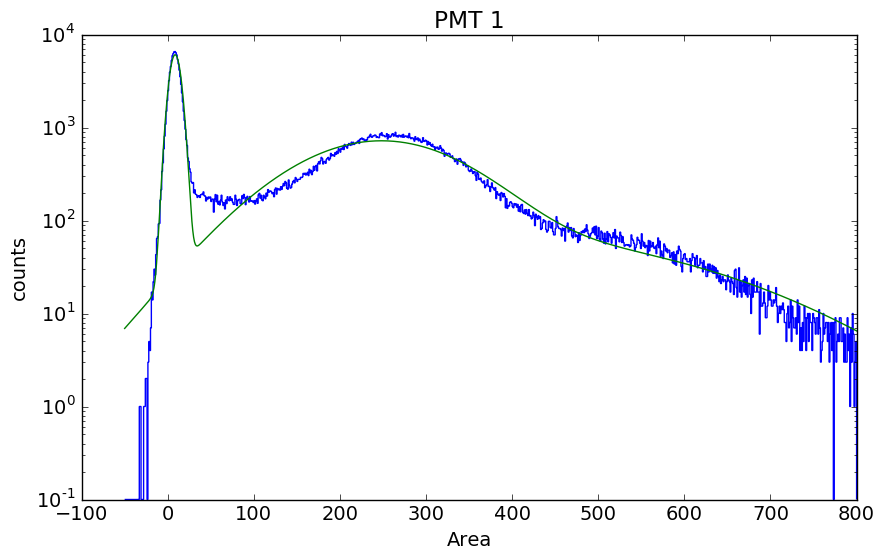

/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf4_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf0_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf2_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf3_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf1_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf3_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf4_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxes

In [72]:
for file in os.listdir(path):
    if 'Figs' in file:
        continue
    print(path+file)
    #channel = int(file.split("_")[1].lstrip("wf"))
    #board = int(file.split("_")[2].lstrip("Board"))
    channel = int(file.split("_")[1].lstrip("wf"))
    board = int(file.split("_")[2].lstrip("Gain"))
    pmt = channel + 1 + board * 7
    if pmt!=1:
        continue
    data = process_ap_file(path+file)
    data = data[data['entropy']<0.8]
    plot_n_fit(data,pmt)